<a href="https://colab.research.google.com/github/lzichi/Thin-Materials-ML/blob/main/2d_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# util

In [ ]:
import os, argparse, time, random
from functools import partial
from shutil import copyfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.optim as optim
import torchvision.models as models
from PIL import Image

from tqdm.notebook import tqdm

In [ ]:
import os

def makedirs(*dirnames):
    for dirname in dirnames:
        if not os.path.exists(dirname):
            os.makedirs(dirname)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random.seed(41)
np.random.seed(41)
torch.manual_seed(41)
torch.cuda.manual_seed_all(41)


In [ ]:
def deactivate_batchnorm(model):
    if isinstance(model, nn.BatchNorm2d):
        model.reset_parameters()
        model.eval()
        with torch.no_grad():
            model.weight.fill_(1.0)
            model.bias.zero_()
            model.requires_grad = False

### Failed method: Focal loss

In [ ]:
def binary_focal_loss_with_logits(
        inp: torch.Tensor,
        target: torch.Tensor,
        alpha: float = .25,
        gamma: float = 2.0,
        reduction: str = 'none',
        eps: float = 1e-8) -> torch.Tensor:
    r"""Function that computes Binary Focal loss.
    args:
        inp (torch.Tensor) : input data tensor
        target (torch.Tensor): the target tensor
        alpha (float): Weighting factor for the rare class :math:`\alpha \in [0, 1]`.  Default: 0.25.
        gamma (float): Focusing parameter :math:`\gamma >= 0`.  Default: 2.0.
        reduction (str, optional): Specifies the reduction to apply to the.  Default: 'none'.
        eps (float): for numerically stability when dividing. Default: 1e-8.
    returns:
        torch.tensor: loss
    Examples:
    >>> num_classes = 1
    >>> kwargs = {"alpha": 0.25, "gamma": 2.0, "reduction": 'mean'}
    >>> logits = torch.tensor([[[[6.325]]],[[[5.26]]],[[[87.49]]]])
    >>> labels = torch.tensor([[[1.]],[[1.]],[[0.]]])
    >>> binary_focal_loss_with_logits(logits, labels, **kwargs)
    tensor(4.6052)
    """

    if not isinstance(inp, torch.Tensor):
        raise TypeError("Input type is not a torch.Tensor. Got {}"
                        .format(type(inp)))

    if not len(inp.shape) >= 2:
        raise ValueError("Invalid input shape, we expect BxCx*. Got: {}"
                         .format(inp.shape))

    if inp.size(0) != target.size(0):
        raise ValueError('Expected input batch_size ({}) to match target batch_size ({}).'
                         .format(inp.size(0), target.size(0)))

    if not inp.device == target.device:
        raise ValueError(
            "input and target must be in the same device. Got: {} and {}".format(
                inp.device, target.device))

    probs = torch.sigmoid(inp)
    target = target.unsqueeze(dim=1)
    loss_tmp = -alpha * torch.pow((1. - probs), gamma) * target * torch.log(probs + eps) \
               - (1 - alpha) * torch.pow(probs, gamma) * (1. - target) * torch.log(1. - probs + eps)
    loss_tmp = loss_tmp.squeeze(dim=1)

    if reduction == 'none':
        loss = loss_tmp
    elif reduction == 'mean':
        loss = torch.mean(loss_tmp)
    elif reduction == 'sum':
        loss = torch.sum(loss_tmp)
    else:
        raise NotImplementedError("Invalid reduction mode: {}"
                                  .format(reduction))
    return loss


class BinaryFocalLossWithLogits(nn.Module):
    r"""Criterion that computes Focal loss.
    According to :cite:`lin2017focal`, the Focal loss is computed as follows:
    .. math::
        \text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma} \, \text{log}(p_t)
    where:
       - :math:`p_t` is the model's estimated probability for each class.
    Arguments:
        alpha (float): Weighting factor for the rare class :math:`\alpha \in [0, 1]`.
        gamma (float): Focusing parameter :math:`\gamma >= 0`.
        reduction (str, optional): Specifies the reduction to apply to the
         output: ‘none’ | ‘mean’ | ‘sum’. ‘none’: no reduction will be applied,
         ‘mean’: the sum of the output will be divided by the number of elements
         in the output, ‘sum’: the output will be summed. Default: ‘none’.
    Shape:
        - Input: :math:`(N, 1, *)`
        - Target: :math:`(N, 1, *)`
    Examples:
        >>> N = 1  # num_classes
        >>> kwargs = {"alpha": 0.25, "gamma": 2.0, "reduction": 'mean'}
        >>> loss = BinaryFocalLossWithLogits(**kwargs)
        >>> input = torch.randn(1, N, 3, 5, requires_grad=True)
        >>> target = torch.empty(1, 3, 5, dtype=torch.long).random_(N)
        >>> output = loss(input, target)
        >>> output.backward()
    """

    def __init__(self, alpha: float, gamma: float = 2.0,
                 reduction: str = 'none') -> None:
        super(BinaryFocalLossWithLogits, self).__init__()
        self.alpha: float = alpha
        self.gamma: float = gamma
        self.reduction: str = reduction
        self.eps: float = 1e-8

    def forward(
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:
        return binary_focal_loss_with_logits(input, target, self.alpha, self.gamma, self.reduction, self.eps)

# Data

In [ ]:
class FlakeDataset(Dataset):
    def __init__(self, df, transform=None, material=None):
        paths, labels, materials, dat_type = [], [], [], []
        for idx, path in enumerate(df['paths']):
            file = path.split('/')[-1].split('.')[0].split('-')[-1]
            if '_crop' in file:
                file = file.split('_crop')[0]
            if material and file not in material:
                continue
            else:
                if 'aug_' in path:
                    dat_type_i = 'augment'
                else:
                    dat_type_i = 'raw'
                dat_type.append(dat_type_i)
                paths.append(path)
                labels.append(df.labels[idx])
                materials.append(file)
        self.path = paths
        self.labels = torch.tensor(labels).float()
        self.materials = np.array(materials)
        self.dat_type = np.array(dat_type)
        
        if not transform:
            transform = transforms.Compose([transforms.ToTensor()])
        self.transform = transform

    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, i):
        if torch.is_tensor(i):
            i = i.tolist()
            
        img = Image.open(self.path[i]).convert("RGB")
        img = self.transform(img)
        label = self.labels[[i]]
        material = self.materials[i]
        dat_type = self.dat_type[i]
        return img.float(), label, material, dat_type
    

In [ ]:
bsz = 4
data = pd.read_pickle('/content/drive/Shared drives/2d/correct_aug_df_range_10.pkl')
data['paths'] = data['paths'].apply(
    lambda x: '/content/drive/My Drive/2d/data/correct_augment_data/' + x.split('/')[2])

In [ ]:
transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                transforms.ToTensor()])

transform = transforms.Compose([
                                transforms.ToTensor()])

# specific_material = ['MoSe2_on_PDMS']
dataset = FlakeDataset(data, transform, material=None)
mat = pd.Series(dataset.materials)
mat.value_counts()

MoSe2_on_si_PDMS    5456
MoSe2_on_Si         3472
MoSe2_on_PDMS       1364
dtype: int64

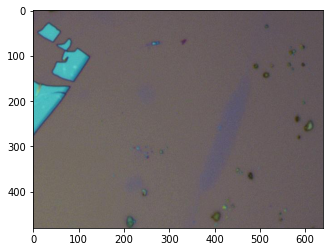

In [ ]:
raw = 0
plt.imshow(np.moveaxis(dataset[raw][0].cpu().numpy(), (0, 1, 2), (2, 0, 1)))

In [ ]:
name = data.names[0].split('_', 1)[1]

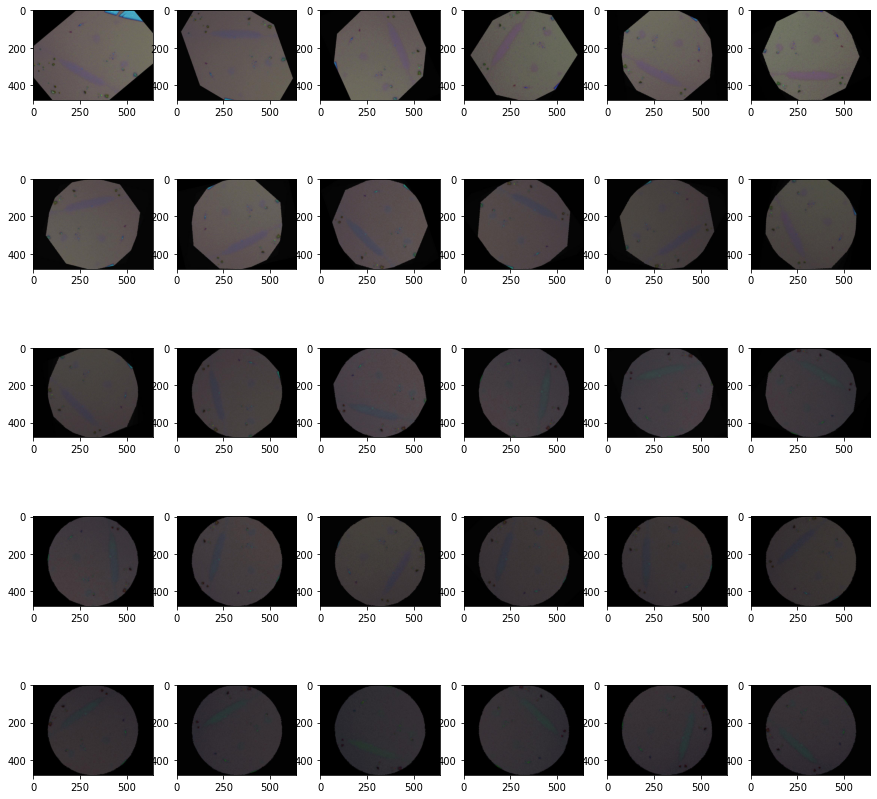

In [ ]:

fig = plt.figure(figsize=(15, 15))
i = 1
for idx, file in enumerate(data.names):
    if name in file and 'raw' not in file:
        fig.add_subplot(5, 6, i)
        _ = plt.imshow(np.moveaxis(dataset[idx][0].cpu().numpy(), (0, 1, 2), (2, 0, 1)))
        plt.title(f'augmented: {i}')
        i += 1

_ = plt.show()

# Train jointly, check materials / data type influence.

## Base

In [ ]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()])

specific_material = None
dataset = FlakeDataset(data, transform, specific_material)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

bsz = 4
train_loader = DataLoader(trainset, batch_size=bsz, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(testset, batch_size=bsz, shuffle=True, num_workers=4, pin_memory=True)

net = models.resnet18(pretrained=False)
fc_features = net.fc.in_features
net.fc = nn.Linear(fc_features, 1)
net = net.to(device)

# deactivate_batchnorm(net)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

epochs = 50
for e in range(1, epochs + 1):
    train_loss = 0.
    train_correct = 0
    train_total = 0
    with tqdm(train_loader, desc=f"{e} / {epochs} epochs:") as t:
        net.train()
        for i, (inputs, labels, material, dat_type) in enumerate(t):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pred = (outputs > 0)
            train_loss += loss.item() * labels.shape[0]
            train_correct += (pred==labels).sum().item()
            train_total += labels.shape[0]
            if i < len(t)-1:
                t.set_postfix({"train_loss": train_loss/train_total, 
                               "train_acc": train_correct/train_total})
            else:
                val_loss = 0.
                val_correct = 0
                val_total = 0
                with torch.no_grad():
                    net.eval()
                    sep_corr = {'MoSe2_on_si_PDMS': 0., 'MoSe2_on_Si': 0., 'MoSe2_on_PDMS': 0.}
                    sep_total = {'MoSe2_on_si_PDMS': 0., 'MoSe2_on_Si': 0., 'MoSe2_on_PDMS': 0.}
                    for i, (inputs, labels, material, dat_type) in enumerate(test_loader):
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = net(inputs)
                        loss = criterion(outputs, labels)

                        pred = (outputs > 0)
                        val_loss += loss.item() * labels.shape[0]
                        val_correct += (pred==labels).sum().item()
                        val_total += labels.shape[0]

                        material = np.array(material)
                        for mat in ['MoSe2_on_si_PDMS', 'MoSe2_on_Si', 'MoSe2_on_PDMS']:
                            pred_mat = pred[material == mat]
                            label_mat = labels[material == mat]
                            sep_corr[mat] += (pred_mat == label_mat).sum().item()
                            sep_total[mat] += label_mat.shape[0]
                        t.set_postfix({"train_loss": train_loss / train_total,
                                       "train_acc": train_correct / train_total,
                                       "val_loss": val_loss / val_total, 
                                       "val_acc": val_correct / val_total,
                                       "val_acc: MoSe2_on_si_PDMS": sep_corr['MoSe2_on_si_PDMS'] / max(sep_total['MoSe2_on_si_PDMS'], 1),
                                       "val_acc: MoSe2_on_Si": sep_corr['MoSe2_on_Si'] / max(sep_total['MoSe2_on_Si'], 1),
                                       "val_acc: MoSe2_on_PDMS": sep_corr['MoSe2_on_PDMS'] / max(sep_total['MoSe2_on_PDMS'], 1),
                                       })

net.eval()

## Focal loss

has no effect

In [ ]:
# transform = transforms.Compose([transforms.Resize(size=(224, 224)),
#                                 transforms.ToTensor()])
# specific_material = None
# dataset = FlakeDataset(data, transform, specific_material)

# train_size = int(len(dataset) * 0.8)
# test_size = len(dataset) - train_size
# trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

# # train_loader = DataLoader(trainset, batch_size=bsz, shuffle=True)
# # test_loader = DataLoader(testset, batch_size=bsz, shuffle=True)
# train_loader = DataLoader(trainset, batch_size=bsz, shuffle=True, num_workers=4, pin_memory=True)
# test_loader = DataLoader(testset, batch_size=bsz, shuffle=True, num_workers=4, pin_memory=True)

# net = models.resnet18(pretrained=False)
# fc_features = net.fc.in_features
# net.fc = nn.Linear(fc_features, 1)
# net = net.to(device)

# deactivate_batchnorm(net)

# criterion = BinaryFocalLossWithLogits(alpha=.5, gamma=2., reduction='mean').to(device)
# optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

# epochs = 50
# for e in range(1, epochs + 1):
#     train_loss = 0.
#     train_correct = 0
#     train_total = 0
#     with tqdm(train_loader, desc=f"{e} / {epochs} epochs:") as t:
#         net.train()
#         for i, (inputs, labels, material, dat_type) in enumerate(t):
#             inputs = inputs.to(device)
#             labels = labels.long().to(device)
#             outputs = net(inputs)
#             loss = criterion(outputs, labels)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             pred = (outputs > 0)
#             train_loss += loss.item() * labels.shape[0]
#             train_correct += (pred==labels).sum().item()
#             train_total += labels.shape[0]
#             if i < len(t)-1:
#                 t.set_postfix({"train_loss": train_loss/train_total, 
#                                "train_acc": train_correct/train_total})
#             else:
#                 val_loss = 0.
#                 val_correct = 0
#                 val_total = 0
#                 with torch.no_grad():
#                     net.eval()
#                     sep_corr = {'MoSe2_on_si_PDMS': 0., 'MoSe2_on_Si': 0., 'MoSe2_on_PDMS': 0.}
#                     sep_total = {'MoSe2_on_si_PDMS': 0., 'MoSe2_on_Si': 0., 'MoSe2_on_PDMS': 0.}
#                     # sep_loss = {'MoSe2_on_si_PDMS': 0., 'MoSe2_on_Si': 0., 'MoSe2_on_PDMS': 0.}
#                     for i, (inputs, labels, material, dat_type) in enumerate(test_loader):
#                         inputs = inputs.to(device)
#                         labels = labels.long().to(device)
#                         outputs = net(inputs)
#                         loss = criterion(outputs, labels)

#                         pred = (outputs > 0)
#                         val_loss += loss.item() * labels.shape[0]
#                         val_correct += (pred==labels).sum().item()
#                         val_total += labels.shape[0]

#                         material = np.array(material)
#                         for mat in ['MoSe2_on_si_PDMS', 'MoSe2_on_Si', 'MoSe2_on_PDMS']:
#                             pred_mat = pred[material == mat]
#                             label_mat = labels[material == mat]
#                             sep_corr[mat] += (pred_mat == label_mat).sum().item()
#                             sep_total[mat] += label_mat.shape[0]
#                         t.set_postfix({"train_loss": train_loss / train_total,
#                                        "train_acc": train_correct / train_total,
#                                        "val_loss": val_loss / val_total, 
#                                        "val_acc": val_correct / val_total,
#                                        "val_acc: MoSe2_on_si_PDMS": sep_corr['MoSe2_on_si_PDMS'] / max(sep_total['MoSe2_on_si_PDMS'], 1),
#                                        "val_acc: MoSe2_on_Si": sep_corr['MoSe2_on_Si'] / max(sep_total['MoSe2_on_Si'], 1),
#                                        "val_acc: MoSe2_on_PDMS": sep_corr['MoSe2_on_PDMS'] / max(sep_total['MoSe2_on_PDMS'], 1),
#                                        })

## Evaluation

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin, is_classifier

class plotClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        super().__init__()

    def transform(self, x):
        return x

    def predict(self, x):
        return self.transform(x)

plotter = plotClassifier()

In [ ]:
labels = []
pred_labels = []
materials = []
dat_types = []

for i, (inputs, label, material, dat_type) in enumerate(test_loader):
    inputs = inputs.to(device)
    outputs = net(inputs)

    pred = (outputs > 0)

    labels.append(label)
    pred_labels.append(pred)
    materials += material
    dat_types += dat_type

pred_labels = torch.cat(pred_labels).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()

result = pd.DataFrame({'label': labels.squeeze(), 'pred': pred_labels.squeeze(), 'material': materials, 'data_type': dat_types})

In [ ]:
print('Materials')
for mat in ['MoSe2_on_si_PDMS', 'MoSe2_on_Si', 'MoSe2_on_PDMS']:
    subset = result[(result.material == mat)]
    print(f'    {mat}: {accuracy_score(subset.label, subset.pred)}')

print('Data type')
for dat in ['augment', 'raw']:
    subset = result[(result.data_type == dat)]
    print(f'    {dat}: {accuracy_score(subset.label, subset.pred)}')

print('Data type and materials')
for mat in ['MoSe2_on_si_PDMS', 'MoSe2_on_Si', 'MoSe2_on_PDMS']:
    for dat in ['augment', 'raw']:
        subset = result[(result.material == mat) & (result.data_type == dat)]
        print(f'    {mat}: {dat}: {accuracy_score(subset.label, subset.pred)}')

Materials
    MoSe2_on_si_PDMS: 0.838475499092559
    MoSe2_on_Si: 0.8401162790697675
    MoSe2_on_PDMS: 0.7992565055762082
Data type
    augment: 0.8333333333333334
    raw: 0.8524590163934426
Data type and materials
    MoSe2_on_si_PDMS: augment: 0.8367537313432836
    MoSe2_on_si_PDMS: raw: 0.9
    MoSe2_on_Si: augment: 0.8395802098950524
    MoSe2_on_Si: raw: 0.8571428571428571
    MoSe2_on_PDMS: augment: 0.803088803088803
    MoSe2_on_PDMS: raw: 0.7


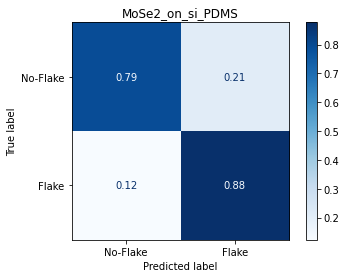

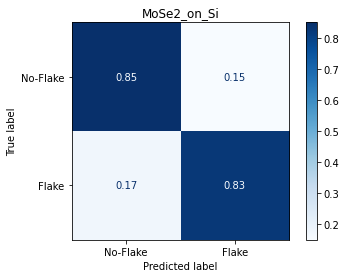

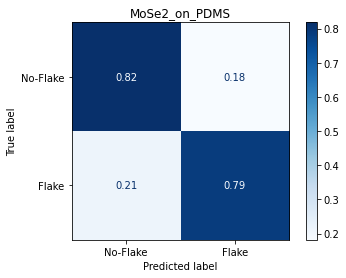

In [ ]:
for mat in ['MoSe2_on_si_PDMS', 'MoSe2_on_Si', 'MoSe2_on_PDMS']:
    subset = result[result.material == mat]
    disp = plot_confusion_matrix(plotter, subset.pred, subset.label, display_labels=[f'No-Flake', f'Flake'], cmap=plt.cm.Blues,
                                 normalize='true')
    disp.ax_.set_title(mat)


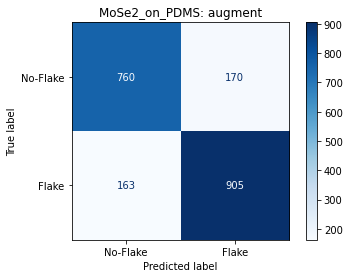

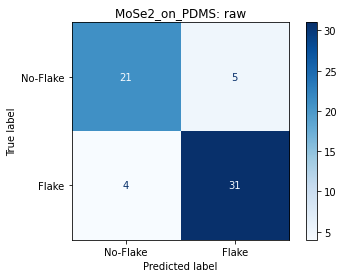

In [ ]:
for dat in ['augment', 'raw']:
    subset = result[(result.data_type == dat)]
    disp = plot_confusion_matrix(plotter, subset.pred, subset.label, display_labels=[f'No-Flake', f'Flake'], cmap=plt.cm.Blues, 
                                 values_format='d', normalize=None)
    disp.ax_.set_title(f'{mat}: {dat}')


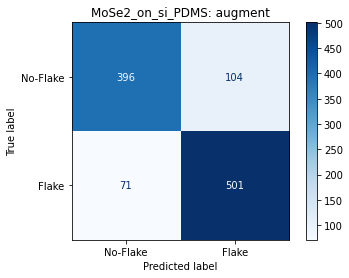

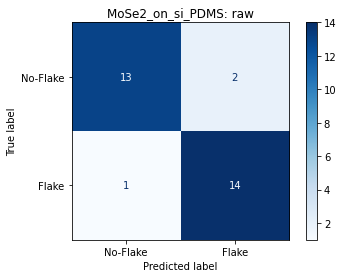

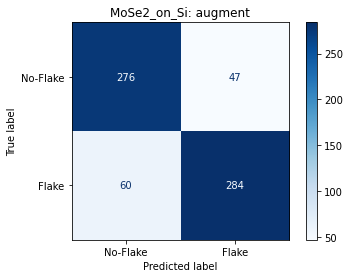

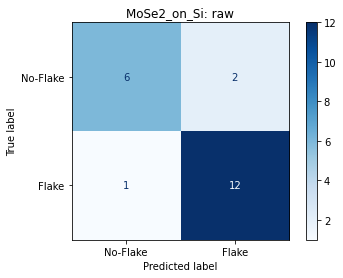

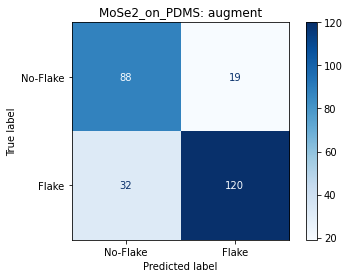

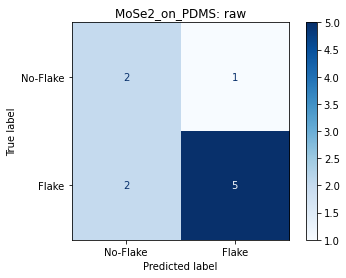

In [ ]:
for mat in ['MoSe2_on_si_PDMS', 'MoSe2_on_Si', 'MoSe2_on_PDMS']:
    for dat in ['augment', 'raw']:
        subset = result[(result.material == mat) & (result.data_type == dat)]
        disp = plot_confusion_matrix(plotter, subset.pred, subset.label, display_labels=[f'No-Flake', f'Flake'], cmap=plt.cm.Blues,
                                     values_format='d',
                                    normalize=None)
        disp.ax_.set_title(f'{mat}: {dat}')


# Train separately

## 1 MoSe2_on_si_PDMS

In [ ]:
transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                transforms.ToTensor()])
specific_material = ['MoSe2_on_si_PDMS']
dataset = FlakeDataset(data, transform, specific_material)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(trainset, batch_size=bsz, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(testset, batch_size=bsz, shuffle=True, num_workers=4, pin_memory=True)

net = models.resnet18(pretrained=False)
fc_features = net.fc.in_features
net.fc = nn.Linear(fc_features, 1)
net = net.to(device)

# deactivate_batchnorm(net)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

epochs = 50
for e in range(1, epochs + 1):
    train_loss = 0.
    train_correct = 0
    train_total = 0
    with tqdm(train_loader, desc=f"{e} / {epochs} epochs:") as t:
        net.train()
        for i, (inputs, labels, material, dat_type) in enumerate(t):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pred = (outputs > 0)
            train_loss += loss.item() * labels.shape[0]
            train_correct += (pred==labels).sum().item()
            train_total += labels.shape[0]
            if i < len(t)-1:
                t.set_postfix({"train_loss": train_loss/train_total, 
                               "train_acc": train_correct/train_total})
            else:
                val_loss = 0.
                val_correct = 0
                val_total = 0
                with torch.no_grad():
                    net.eval()
                    for i, (inputs, labels, material, dat_type) in enumerate(test_loader):
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = net(inputs)
                        loss = criterion(outputs, labels)

                        pred = (outputs > 0)
                        val_loss += loss.item() * labels.shape[0]
                        val_correct += (pred==labels).sum().item()
                        val_total += labels.shape[0]

                        t.set_postfix({"train_loss": train_loss / train_total,
                                       "train_acc": train_correct / train_total,
                                       "val_loss": val_loss / val_total, 
                                       "val_acc": val_correct / val_total,
                                       })

In [ ]:
labels = []
pred_labels = []
materials = []
dat_types = []

for i, (inputs, label, material, dat_type) in enumerate(test_loader):
    inputs = inputs.to(device)
    outputs = net(inputs)

    pred = (outputs > 0)

    labels.append(label)
    pred_labels.append(pred)
    materials += material
    dat_types += dat_type

pred_labels = torch.cat(pred_labels).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()

result = pd.DataFrame({'label': labels.squeeze(), 'pred': pred_labels.squeeze(), 'material': materials, 'data_type': dat_types})

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin, is_classifier

class plotClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        super().__init__()

    def transform(self, x):
        return x

    def predict(self, x):
        return self.transform(x)

plotter = plotClassifier()

In [ ]:
print(accuracy_score(result.label, result.pred))

print('Data type')
for dat in ['augment', 'raw']:
    subset = result[(result.data_type == dat)]
    print(f'    {dat}: {accuracy_score(subset.label, subset.pred)}')

0.7902930402930403
Data type
    augment: 0.7912297426120114
    raw: 0.7674418604651163


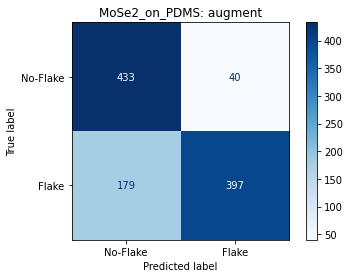

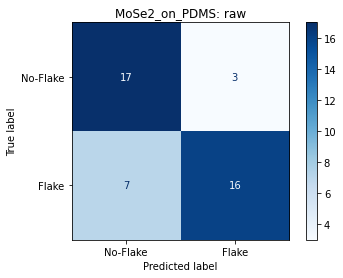

In [ ]:
for dat in ['augment', 'raw']:
    subset = result[(result.data_type == dat)]
    disp = plot_confusion_matrix(plotter, subset.pred, subset.label, display_labels=[f'No-Flake', f'Flake'], cmap=plt.cm.Blues, 
                                 values_format='d', normalize=None)
    disp.ax_.set_title(f'{specific_material}: {dat}')


## 2 MoSe2_on_Si

In [ ]:
transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                transforms.ToTensor()])
specific_material = ['MoSe2_on_Si']
dataset = FlakeDataset(data, transform, specific_material)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(trainset, batch_size=bsz, shuffle=True, num_workers=4, drop_last=True, pin_memory=True)
test_loader = DataLoader(testset, batch_size=bsz, shuffle=True, num_workers=4, drop_last=True, pin_memory=True)

net = models.resnet18(pretrained=False)
fc_features = net.fc.in_features
net.fc = nn.Linear(fc_features, 1)
net = net.to(device)

# deactivate_batchnorm(net)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

epochs = 50
for e in range(1, epochs + 1):
    train_loss = 0.
    train_correct = 0
    train_total = 0
    with tqdm(train_loader, desc=f"{e} / {epochs} epochs:") as t:
        net.train()
        for i, (inputs, labels, material, dat_type) in enumerate(t):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pred = (outputs > 0)
            train_loss += loss.item() * labels.shape[0]
            train_correct += (pred==labels).sum().item()
            train_total += labels.shape[0]
            if i < len(t)-1:
                t.set_postfix({"train_loss": train_loss/train_total, 
                               "train_acc": train_correct/train_total})
            else:
                val_loss = 0.
                val_correct = 0
                val_total = 0
                with torch.no_grad():
                    net.eval()
                    for i, (inputs, labels, material, dat_type) in enumerate(test_loader):
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = net(inputs)
                        loss = criterion(outputs, labels)

                        pred = (outputs > 0)
                        val_loss += loss.item() * label.shape[0]
                        val_correct += (pred==labels).sum().item()
                        val_total += label.shape[0]

                        t.set_postfix({"train_loss": train_loss / train_total,
                                       "train_acc": train_correct / train_total,
                                       "val_loss": val_loss / val_total, 
                                       "val_acc": val_correct / val_total,
                                       })

In [ ]:
labels = []
pred_labels = []
materials = []
dat_types = []

for i, (inputs, label, material, dat_type) in enumerate(test_loader):
    inputs = inputs.to(device)
    outputs = net(inputs)

    pred = (outputs > 0)

    labels.append(label)
    pred_labels.append(pred)
    materials += material
    dat_types += dat_type

pred_labels = torch.cat(pred_labels).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()

result = pd.DataFrame({'label': labels.squeeze(), 'pred': pred_labels.squeeze(), 'material': materials, 'data_type': dat_types})

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin, is_classifier

class plotClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        super().__init__()

    def transform(self, x):
        return x

    def predict(self, x):
        return self.transform(x)

plotter = plotClassifier()

In [ ]:
print(accuracy_score(result.label, result.pred))

print('Data type')
for dat in ['augment', 'raw']:
    subset = result[(result.data_type == dat)]
    print(f'    {dat}: {accuracy_score(subset.label, subset.pred)}')

0.791907514450867
Data type
    augment: 0.7890044576523031
    raw: 0.8947368421052632


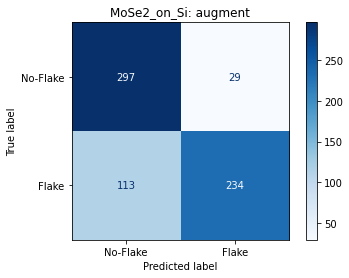

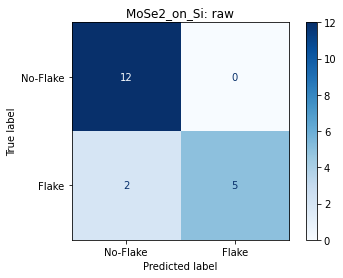

In [ ]:
mat = 'MoSe2_on_Si'
for dat in ['augment', 'raw']:
    subset = result[(result.data_type == dat)]
    disp = plot_confusion_matrix(plotter, subset.pred, subset.label, display_labels=[f'No-Flake', f'Flake'], cmap=plt.cm.Blues, 
                                 values_format='d', normalize=None)
    disp.ax_.set_title(f'{mat}: {dat}')


## 3 MoSe2_on_PDMS

In [ ]:
transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                transforms.ToTensor()])
specific_material = ['MoSe2_on_PDMS']
dataset = FlakeDataset(data, transform, specific_material)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(trainset, batch_size=bsz, shuffle=True)
test_loader = DataLoader(testset, batch_size=bsz, shuffle=True)

net = models.resnet18(pretrained=False)
fc_features = net.fc.in_features
net.fc = nn.Linear(fc_features, 1)
net = net.to(device)

# deactivate_batchnorm(net)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

epochs = 50
for e in range(1, epochs + 1):
    train_loss = 0.
    train_correct = 0
    train_total = 0
    with tqdm(train_loader, desc=f"{e} / {epochs} epochs:") as t:
        net.train()
        for i, (inputs, labels, material, dat_type) in enumerate(t):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pred = (outputs > 0)
            train_loss += loss.item() * labels.shape[0]
            train_correct += (pred==labels).sum().item()
            train_total += labels.shape[0]
            if i < len(t)-1:
                t.set_postfix({"train_loss": train_loss/train_total, 
                               "train_acc": train_correct/train_total})
            else:
                val_loss = 0.
                val_correct = 0
                val_total = 0
                with torch.no_grad():
                    net.eval()
                    for i, (inputs, labels, material, dat_type) in enumerate(test_loader):
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = net(inputs)
                        loss = criterion(outputs, labels)

                        pred = (outputs > 0)
                        val_loss += loss.item() * label.shape[0]
                        val_correct += (pred==labels).sum().item()
                        val_total += label.shape[0]

                        t.set_postfix({"train_loss": train_loss / train_total,
                                       "train_acc": train_correct / train_total,
                                       "val_loss": val_loss / val_total, 
                                       "val_acc": val_correct / val_total,
                                       })

In [ ]:
labels = []
pred_labels = []
materials = []
dat_types = []

for i, (inputs, label, material, dat_type) in enumerate(test_loader):
    inputs = inputs.to(device)
    outputs = net(inputs)

    pred = (outputs > 0)

    labels.append(label)
    pred_labels.append(pred)
    materials += material
    dat_types += dat_type

pred_labels = torch.cat(pred_labels).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()

result = pd.DataFrame({'label': labels.squeeze(), 'pred': pred_labels.squeeze(), 'material': materials, 'data_type': dat_types})

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin, is_classifier

class plotClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        super().__init__()

    def transform(self, x):
        return x

    def predict(self, x):
        return self.transform(x)

plotter = plotClassifier()

In [ ]:
print(accuracy_score(result.label, result.pred))

print('Data type')
for dat in ['augment', 'raw']:
    subset = result[(result.data_type == dat)]
    print(f'    {dat}: {accuracy_score(subset.label, subset.pred)}')

0.7435897435897436
Data type
    augment: 0.7414448669201521
    raw: 0.8


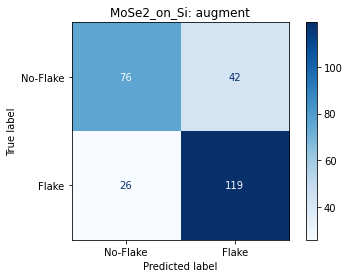

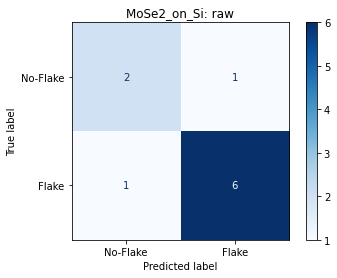

In [ ]:
for dat in ['augment', 'raw']:
    subset = result[(result.data_type == dat)]
    disp = plot_confusion_matrix(plotter, subset.pred, subset.label, display_labels=[f'No-Flake', f'Flake'], cmap=plt.cm.Blues, 
                                 values_format='d', normalize=None)
    disp.ax_.set_title(f'{mat}: {dat}')


# Quantized pixel



## Data

In [ ]:
# from sklearn.cluster import KMeans 


# class QuantizableFlakeDataset(Dataset):
#     def __init__(self, df, 
#                  transform=None, 
#                  material=None, 
#                  num_colors=0,
#                  random_state=1,
#                  **kwargs):
        
#         self.random_state = random_state
#         random.seed(self.random_state)
#         np.random.seed(self.random_state)
#         torch.manual_seed(self.random_state)
#         torch.cuda.manual_seed_all(self.random_state)
        
#         paths, labels, materials, dat_type = [], [], [], []
#         for idx, path in enumerate(df['paths']):
#             file = path.split('/')[-1].split('.')[0].split('-')[-1]
#             if '_crop' in file:
#                 file = file.split('_crop')[0]
#             if material and file not in material:
#                 continue
#             else:
#                 if 'aug_' in path:
#                     dat_type_i = 'augment'
#                 else:
#                     dat_type_i = 'raw'
#                 dat_type.append(dat_type_i)
#                 paths.append(path)
#                 labels.append(df.labels[idx])
#                 materials.append(file)
#         self.path = paths
#         self.labels = torch.tensor(labels).float()
#         self.materials = np.array(materials)
#         self.dat_type = np.array(dat_type)
        
#         if not transform:
#             transform = transforms.Compose([transforms.ToTensor()])
#         self.transform = transform

#         self.num_colors = num_colors
#         self.to_quantize_img = not (self.num_colors <= 0 
#                                     or self.num_colors is None)
#         if self.to_quantize_img:
#             self.kmeans = KMeans(n_clusters=self.num_colors, 
#                                 random_state=self.random_state)
#             self.kmeans_size = kwargs.get('kmeans_size', 1000)

#     def quantize_img(self, img):

#         img = img.permute(1, 2, 0)
#         w, h, c = img.shape
#         img_flatten = torch.reshape(img, (w*h, c))
#         pixel_sample = img_flatten[torch.randperm(w*h)[:self.kmeans_size]]        
#         kmeans = self.kmeans.fit(pixel_sample)

#         labels = kmeans.predict(img_flatten)        
#         centroids = kmeans.cluster_centers_
#         # return kmeans        
#         new_img = torch.from_numpy(centroids[labels.reshape(w, h)])
#         return new_img.permute(2, 0, 1)

#     def __len__(self):
#         return len(self.path)
    
#     def __getitem__(self, i):
#         if torch.is_tensor(i):
#             i = i.tolist()
            
#         img = Image.open(self.path[i]).convert("RGB")
#         img = self.transform(img)
#         if self.to_quantize_img:
#             img = self.quantize_img(img)

#         label = self.labels[[i]]
#         material = self.materials[i]
#         dat_type = self.dat_type[i]
#         return img.float(), label, material, dat_type
    

In [ ]:
# bsz = 4

# data = pd.read_pickle('/content/drive/My Drive/2d/data/correct_aug_df_range_10.pkl')
# data['paths'] = data['paths'].apply(lambda x: '/content/drive/My Drive/2d/data/correct_augment_data/' + x.split('/')[2])

## Train jointly

In [ ]:
# import warnings
# warnings.simplefilter("ignore")

# transform = transforms.Compose([transforms.Resize(size=(224, 224)),
#                                 transforms.ToTensor()])
# specific_material = None
# dataset = QuantizableFlakeDataset(data, transform, specific_material, 
#                                   num_colors=5)

# train_size = int(len(dataset) * 0.8)
# test_size = len(dataset) - train_size
# trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

# train_loader = DataLoader(trainset, batch_size=bsz, shuffle=True)
# test_loader = DataLoader(testset, batch_size=bsz, shuffle=True)

# net = models.resnet18(pretrained=False)
# fc_features = net.fc.in_features
# net.fc = nn.Linear(fc_features, 1)
# net = net.to(device)

# deactivate_batchnorm(net)

# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

# epochs = 50
# for e in range(1, epochs + 1):
#     train_loss = 0.
#     train_correct = 0
#     train_total = 0
#     with tqdm(train_loader, desc=f"{e} / {epochs} epochs:") as t:
#         net.train()
#         for i, (inputs, labels, material, dat_type) in enumerate(t):
#             inputs = inputs.to(device)
#             labels = labels.to(device).float()
#             outputs = net(inputs)
#             loss = criterion(outputs, labels)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             pred = (outputs > 0)
#             train_loss += loss.item() * labels.shape[0]
#             train_correct += (pred==labels).sum().item()
#             train_total += labels.shape[0]
#             if i < len(t)-1:
#                 t.set_postfix({"train_loss": train_loss/train_total, 
#                                "train_acc": train_correct/train_total})
#             else:
#                 val_loss = 0.
#                 val_correct = 0
#                 val_total = 0
#                 with torch.no_grad():
#                     net.eval()
#                     sep_corr = {'MoSe2_on_si_PDMS': 0., 'MoSe2_on_Si': 0., 'MoSe2_on_PDMS': 0.}
#                     sep_total = {'MoSe2_on_si_PDMS': 0., 'MoSe2_on_Si': 0., 'MoSe2_on_PDMS': 0.}
#                     # sep_loss = {'MoSe2_on_si_PDMS': 0., 'MoSe2_on_Si': 0., 'MoSe2_on_PDMS': 0.}
#                     for i, (inputs, labels, material, dat_type) in enumerate(test_loader):
#                         inputs = inputs.to(device)
#                         labels = labels.to(device)
#                         outputs = net(inputs)
#                         loss = criterion(outputs, labels)

#                         pred = (outputs > 0)
#                         val_loss += loss.item() * labels.shape[0]
#                         val_correct += (pred==labels).sum().item()
#                         val_total += labels.shape[0]

#                         material = np.array(material)
#                         for mat in ['MoSe2_on_si_PDMS', 'MoSe2_on_Si', 'MoSe2_on_PDMS']:
#                             pred_mat = pred[material == mat]
#                             label_mat = labels[material == mat]
#                             sep_corr[mat] += (pred_mat == label_mat).sum().item()
#                             sep_total[mat] += label_mat.shape[0]
#                         t.set_postfix({"train_loss": train_loss / train_total,
#                                        "train_acc": train_correct / train_total,
#                                        "val_loss": val_loss / val_total, 
#                                        "val_acc": val_correct / val_total,
#                                        "val_acc: MoSe2_on_si_PDMS": sep_corr['MoSe2_on_si_PDMS'] / max(sep_total['MoSe2_on_si_PDMS'], 1),
#                                        "val_acc: MoSe2_on_Si": sep_corr['MoSe2_on_Si'] / max(sep_total['MoSe2_on_Si'], 1),
#                                        "val_acc: MoSe2_on_PDMS": sep_corr['MoSe2_on_PDMS'] / max(sep_total['MoSe2_on_PDMS'], 1),
#                                        })

In [ ]:
# labels = []
# pred_labels = []
# materials = []
# dat_types = []

# for i, (inputs, label, material, dat_type) in enumerate(test_loader):
#     inputs = inputs.to(device)
#     outputs = net(inputs)

#     pred = (outputs > 0)

#     labels.append(label)
#     pred_labels.append(pred)
#     materials += material
#     dat_types += dat_type

# pred_labels = torch.cat(pred_labels).cpu().numpy()
# labels = torch.cat(labels).cpu().numpy()

# result = pd.DataFrame({'label': labels.squeeze(), 'pred': pred_labels.squeeze(), 'material': materials, 'data_type': dat_types})